In [1]:
## Demonstration of how to obtain source function, optical depth
##  and contribution function.

import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

import rhanalyze
from rhanalyze.satlas import satlas

In [2]:
## Read in output data from run

rhd1 = rhanalyze.rhout('/home/han/Source/rh_v2/rhf1d/run_FALC')

lambda_0:  854.2085677754852
Shape of source function S: (82,)
Shape of Planck function: Bp (82,)
Shape of optical depth tau: (82,)


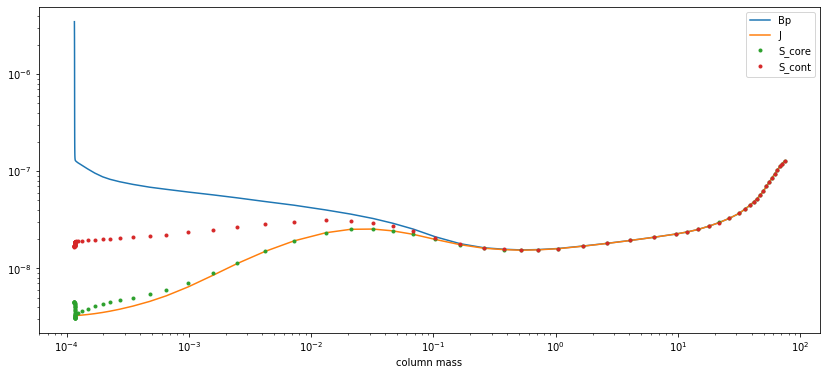

In [3]:
## Preload the FTS atlas
fts = satlas()

# Get parameters of your favorite line and atom

ATOMNO = 0      ## ['Ca', 'H', 'Na']
LINENO = 4
DWING  = 22
DLAMB  = 2.0

lambda0 = rhd1.atoms[ATOMNO].transition[LINENO].lambda0
print("lambda_0: ", lambda0)
lambda_blue = lambda0 - DLAMB
lambda_red  = lambda0 + DLAMB

obs = fts.nmsiatlas(lambda_blue, lambda_red)

index = np.where((rhd1.spectrum.waves >= lambda_blue) & \
                 (rhd1.spectrum.waves <= lambda_red))
lblue = index[0][0]
lred  = index[0][-1]
icore = np.where(rhd1.spectrum.waves == lambda0)
lcore = icore[0][0]
lwing = lcore - DWING

## read the opacity for wavelength index waveno and ray index rayno

rayno  = rhd1.geometry.Nrays-1

rhd1.opacity.read(lcore, rayno)

# Evaluate source function for that wavelength and viewing angle
# Stored in rhd1.opacity.S
rhd1.opacity.Source()
print("Shape of source function S:", np.shape(rhd1.opacity.S))

# Evaluate Planck function for the same wavelength
# Stored in # Stored in rhd1.opacity.Bp
rhd1.opacity.Planck()
print("Shape of Planck function: Bp", np.shape(rhd1.opacity.Bp))

# Stored in rhd1.opacity.tau
# Evaluate optical depth at disk center
rhd1.opacity.get_tau(center=True)
print("Shape of optical depth tau:", np.shape(rhd1.opacity.tau))

plt.figure(figsize=[14,6])

plt.plot(rhd1.geometry.cmass, rhd1.opacity.Bp, label='Bp')
plt.plot(rhd1.geometry.cmass, rhd1.opacity.J, label='J')
plt.plot(rhd1.geometry.cmass, rhd1.opacity.S, '.', label='S_core')

rhd1.opacity.read(lblue, rayno)
rhd1.opacity.Source()

plt.plot(rhd1.geometry.cmass, rhd1.opacity.S, '.', label='S_cont')

plt.xlabel('column mass')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# Contribution function $C$

The formal solution of the transfer equation: 

>$  I = \int_{0}^{\infty} S(\tau) e^{-\tau} \frac{\mathrm{d} \tau}{\mathrm{d} h} \mathrm{d} h$

The integrant is the Contribution Function:

>$  C = S(\tau) e^{-\tau} \frac{\mathrm{d} \tau}{\mathrm{d} h}$

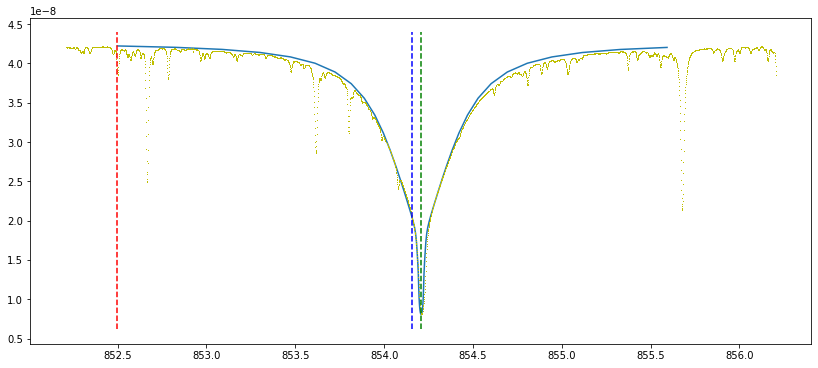

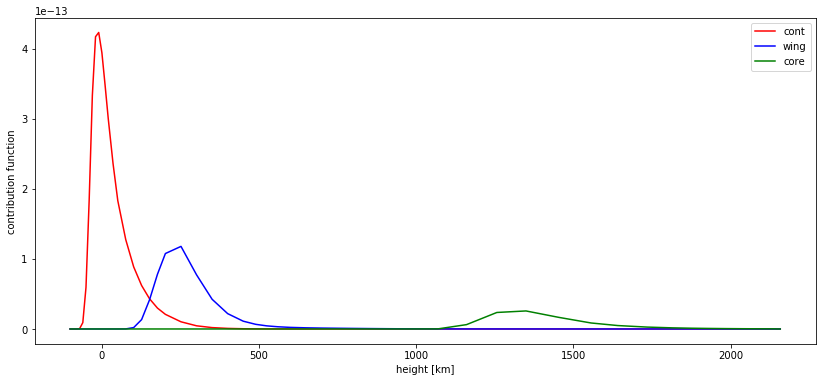

In [4]:
# Define indices for continuum, wing and core
ldisp = [lblue, lwing, lcore]
label = ['cont', 'wing', 'core']
color = ['r', 'b', 'g']

plt.figure(figsize=[14, 6])

I = rhd1.rays[0].I
waves = rhd1.spectrum.waves

plt.plot(waves[lblue:lred], I[lblue:lred])
plt.plot(obs[0], obs[1], "y,", label='atlas')

yminmax = plt.ylim()
for l in range(len(ldisp)):
    plt.plot([waves[ldisp[l]], waves[ldisp[l]]], yminmax, color[l]+'--')

plt.show()

## Calculate the contribution function for the selected wavelength indices
plt.figure(figsize=[14, 6])
for l in range(len(ldisp)):

    rhd1.opacity.read(ldisp[l], rhd1.geometry.Nrays-1)
    rhd1.opacity.Source()
    rhd1.opacity.get_tau(center=True)

    ## Derivative of tau wrt height (note negative because index of height is reversed)
    dtaudh = -np.gradient(rhd1.opacity.tau, rhd1.geometry.height)
    contrib = rhd1.opacity.S * np.exp(-rhd1.opacity.tau) * dtaudh

    plt.plot(rhd1.geometry.height/1.0E3, contrib, color[l], label=label[l])
    
plt.xlabel('height [km]')
plt.ylabel('contribution function')
plt.legend()
plt.show()

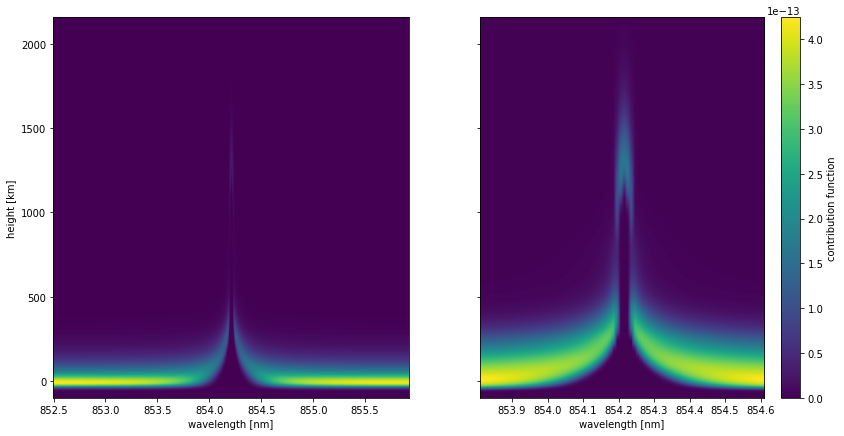

In [5]:
# Contribution of whole line

Nwave = lred - lblue
contrib = np.zeros([rhd1.geometry.Ndep, Nwave], dtype='float')
for la in range(Nwave):
    rhd1.opacity.read(lblue + la, rhd1.geometry.Nrays-1)
    rhd1.opacity.Source()
    rhd1.opacity.get_tau(center=True)

    ## Derivative of tau wrt height (note negative because index of height is reversed)
    dtaudh = -np.gradient(rhd1.opacity.tau, rhd1.geometry.height)
    contrib[:, la] = rhd1.opacity.S * np.exp(-rhd1.opacity.tau) * dtaudh
    
# Height in km
kms = rhd1.geometry.height/1.E3

## Interpolate onto a linear wavelength and height grid

f_contr = interpolate.interp2d(waves[lblue:lred], kms, contrib, kind='cubic')

wave_lin  = np.arange(waves[lblue], waves[lred], 0.01)
kms_lin   = np.arange(kms[-1], kms[0], 10.0)
contr_lin = f_contr(wave_lin, kms_lin)

## Display map
fig, axs = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
im = axs[0].imshow(contr_lin, interpolation='bilinear', origin='lower',\
                   extent=[waves[lblue], waves[lred], kms[-1], kms[0]],\
                   aspect="auto")
axs[0].set(xlabel='wavelength [nm]', ylabel='height [km]')

plt.colorbar(im, label='contribution function')

## Display map inner part of line
wave_lin2  = np.arange(waves[lcore]-0.4, waves[lcore]+0.4, 0.01)
contr_lin2 = f_contr(wave_lin2, kms_lin)

im2 = axs[1].imshow(np.log(contr_lin2 + 1.0E-14), interpolation='bilinear', origin='lower',\
                    extent=[waves[lcore]-0.4, waves[lcore]+0.4, kms[-1], kms[0]],\
                    aspect="auto")

axs[1].set(xlabel='wavelength [nm]')

plt.show()
